In [125]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    SGDClassifier
)

from sklearn.svm import (
    LinearSVC,
    SVC
)

from sklearn.metrics import (
    precision_recall_curve, 
    f1_score, 
    roc_curve,
    auc,
    precision_score,
    recall_score,
    mean_squared_error,
    confusion_matrix
)

import collections
import re

# from scipy.stats import pearsonr, interval
import scipy.stats as st

dat = pd.read_pickle('data_cleaned/Fenty_Beauty_by_Rihanna_Pro_Filtr_Soft_Matte_Longwear_Liquid_Foundation.pkl')

### Exploring the data

#### Could we train different models for customers who purchased the same shades?

In [126]:
# first look at the distribution
dat['shade_number'] = int()
for i in tqdm(range(len(dat))):
    if type(dat.loc[i, 'purchased_shade']) == float:
        dat.loc[i, 'purchased_shade'] = None
        dat.loc[i, 'shade_number'] = None
    if dat.loc[i, 'purchased_shade']:
        dat.loc[i, 'shade_number'] = int(re.match(r'^...',dat.loc[i, 'purchased_shade'])[0])

100%|██████████| 5993/5993 [00:00<00:00, 10944.44it/s]


In [127]:
dat = dat.sort_values(['shade_number'], axis = 0, na_position='last')

In [128]:
shades = dat.groupby(['shade_number'], as_index=False).count()
shades.shape # we have 49 different shades with this foundation

(49, 12)

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


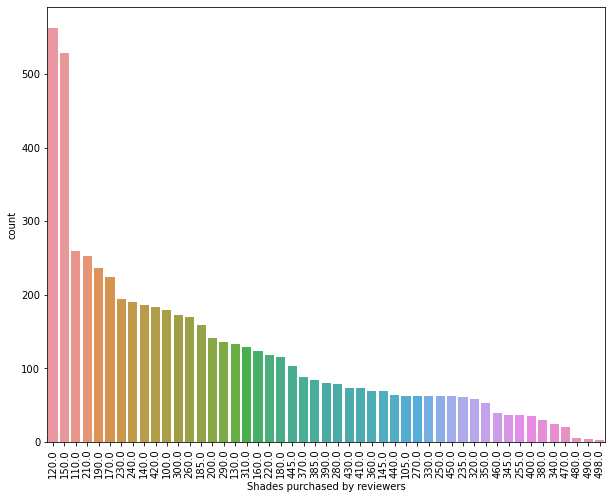

In [129]:
# shades = dat.groupby(['shade_number'], as_index=False)#.count()
plt.figure(figsize=(10,8))
sns.countplot(dat['shade_number'], order = dat['shade_number'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Shades purchased by reviewers')
plt.savefig('fenty_shades_purchased_by_reviewers.jpeg')

In [130]:
# not feasible since the sample sizes are too small if we subset reviews by shade purchased
dat = dat.sample(frac=1, random_state = 0)

### Preparing the training and validation sets

In [131]:
dat['skin_tone_cat'] = 0

for i in range(len(dat)):
    if dat.loc[i, 'skin_tone'] == 'Dark' or dat.loc[i, 'skin_tone'] == 'Ebony' or dat.loc[i, 'skin_tone'] == 'Deep':
        dat.loc[i, 'skin_tone_cat'] = 0 # darker skin tone = 0
    else:
        dat.loc[i, 'skin_tone_cat'] = 1 # ligher skin tone = 1

In [132]:
reviewer_features = ['hair_color', 'eye_color', 'skin_tone', 'skin_type', 'skin_tone_cat']

X = dat[reviewer_features]
y = dat['rating']
dat.loc[:, '5-stars'] = np.where(dat.loc[:, 'rating']==5,1,0)
bin_y = dat['5-stars']


train_X, val_X, train_bin_y, val_bin_y = train_test_split(X, bin_y,test_size=0.3, random_state=0)

In [133]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.3, random_state=0)

In [134]:
train_X.head()

,hair_color,eye_color,skin_tone,skin_type,skin_tone_cat
2755,Black,Brown,Medium,Oily,1
2113,Blonde,Blue,Fair,Combination,1
5684,Brunette,Brown,Medium,Combination,1
3689,Brunette,Hazel,Olive,Combination,1
3557,Black,Brown,Light,Dry,1


#### One-hot Encoding Reviewer Features

##### Hair colors and eye colors

In [135]:
enc_rest = OneHotEncoder(sparse=False)
train_X_transform = enc_rest.fit_transform(train_X[['hair_color', 'eye_color']])
val_X_transform = enc_rest.transform(val_X[['hair_color', 'eye_color']])

train_X_transform = pd.DataFrame(train_X_transform)
val_X_transform = pd.DataFrame(val_X_transform)

In [136]:
train_X.groupby(['hair_color'],as_index=False).count()

,hair_color,eye_color,skin_tone,skin_type,skin_tone_cat
0,,74,74,74,74
1,Auburn,116,116,116,116
2,Black,1166,1166,1166,1166
3,Blonde,787,787,787,787
4,Brunette,1921,1921,1921,1921
5,Gray,19,19,19,19
6,Red,112,112,112,112


In [137]:
train_X.groupby(['eye_color'],as_index=False).count()

,eye_color,hair_color,skin_tone,skin_type,skin_tone_cat
0,,110,110,110,110
1,Blue,690,690,690,690
2,Brown,2477,2477,2477,2477
3,Gray,32,32,32,32
4,Green,419,419,419,419
5,Hazel,467,467,467,467


#### Skin types and skin tones

In [138]:
enc_skin_tone = OneHotEncoder(sparse=False)
train_X_transform_skin_tone = enc_skin_tone.fit_transform(train_X[['skin_tone']])
val_X_transform_skin_tone = enc_skin_tone.transform(val_X[['skin_tone']])

# enc_skin_tone_cat = OneHotEncoder(sparse=False)
# train_X_transform_skin_tone_cat = enc_skin_tone.fit_transform(train_X[['skin_tone_cat']])
# val_X_transform_skin_tone_cat = enc_skin_tone.transform(val_X[['skin_tone_cat']])

enc_skin_type = OneHotEncoder(sparse=False)
train_X_transform_skin_type = enc_skin_type.fit_transform(train_X[['skin_type']])
val_X_transform_skin_type = enc_skin_type.transform(val_X[['skin_type']])

In [139]:
train_X.groupby(['skin_type'],as_index=False).count()

,skin_type,hair_color,eye_color,skin_tone,skin_tone_cat
0,,12,12,12,12
1,Combination,2239,2239,2239,2239
2,Dry,472,472,472,472
3,Normal,470,470,470,470
4,Oily,1002,1002,1002,1002


In [140]:
train_X.groupby(['skin_tone'],as_index=False).count()

,skin_tone,hair_color,eye_color,skin_type,skin_tone_cat
0,,14,14,14,14
1,Dark,233,233,233,233
2,Deep,378,378,378,378
3,Ebony,54,54,54,54
4,Fair,714,714,714,714
5,Light,920,920,920,920
6,Medium,798,798,798,798
7,Olive,350,350,350,350
8,Porcelain,331,331,331,331
9,Tan,403,403,403,403


In [141]:
train_X.groupby(['skin_tone_cat'],as_index=False).count()

,skin_tone_cat,hair_color,eye_color,skin_tone,skin_type
0,0,665,665,665,665
1,1,3530,3530,3530,3530


In [142]:
total_skin_tone = len(train_X.groupby(['skin_tone'],as_index=False).count()) # 10
total_skin_type = len(train_X.groupby(['skin_type'],as_index=False).count()) # 5

train_X_cross = pd.DataFrame()


i = 0 # tone
# j = 0 # type
while i <= total_skin_tone - 1:
    j = 0
    while j <= total_skin_type - 1:
        new_cross = train_X_transform_skin_tone[:,i] * train_X_transform_skin_type[:,j]
        new_cross = pd.Series(new_cross)
        train_X_cross[f'{i}_{j}'] = new_cross
        j += 1
    i += 1
    
train_X_cross.head()

,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,1_3,1_4,...,8_0,8_1,8_2,8_3,8_4,9_0,9_1,9_2,9_3,9_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
train_X.groupby(['hair_color'],as_index=False).count()

,hair_color,eye_color,skin_tone,skin_type,skin_tone_cat
0,,74,74,74,74
1,Auburn,116,116,116,116
2,Black,1166,1166,1166,1166
3,Blonde,787,787,787,787
4,Brunette,1921,1921,1921,1921
5,Gray,19,19,19,19
6,Red,112,112,112,112


In [144]:
train_X.groupby(['eye_color'],as_index=False).count()

,eye_color,hair_color,skin_tone,skin_type,skin_tone_cat
0,,110,110,110,110
1,Blue,690,690,690,690
2,Brown,2477,2477,2477,2477
3,Gray,32,32,32,32
4,Green,419,419,419,419
5,Hazel,467,467,467,467


In [145]:
train_X_transform.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [146]:
train_X_transform_skin_tone = pd.DataFrame(train_X_transform_skin_tone)
train_X_transform_skin_type = pd.DataFrame(train_X_transform_skin_type)
train_frames = [train_X_transform, train_X_transform_skin_tone, train_X_transform_skin_type, train_X_cross]
train_X_transform = pd.concat(train_frames, axis=1)

In [147]:
train_X_transform.head()

,0,1,2,3,4,5,6,7,8,9,...,8_0,8_1,8_2,8_3,8_4,9_0,9_1,9_2,9_3,9_4
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Same procedure for validation set

In [148]:
total_skin_tone = len(val_X.groupby(['skin_tone'],as_index=False).count()) # 10
total_skin_type = len(val_X.groupby(['skin_type'],as_index=False).count()) # 5

val_X_cross = pd.DataFrame()

i = 0 # tone
# j = 0 # type
while i <= total_skin_tone - 1:
    j = 0
    while j <= total_skin_type - 1:
        new_cross = val_X_transform_skin_tone[:,i] * val_X_transform_skin_type[:, j]
        new_cross = pd.Series(new_cross)
        val_X_cross[f'{i}_{j}'] = new_cross
        j += 1
    i += 1
    
val_X_cross.head()

,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,1_3,1_4,...,8_0,8_1,8_2,8_3,8_4,9_0,9_1,9_2,9_3,9_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [149]:
val_X_transform_skin_tone = pd.DataFrame(val_X_transform_skin_tone)
val_X_transform_skin_type = pd.DataFrame(val_X_transform_skin_type)
val_frames = [val_X_transform, val_X_transform_skin_tone, val_X_transform_skin_type, val_X_cross]
val_X_transform = pd.concat(val_frames, axis=1)

In [150]:
val_X_transform.shape

(1798, 78)

##### About y (rating)

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

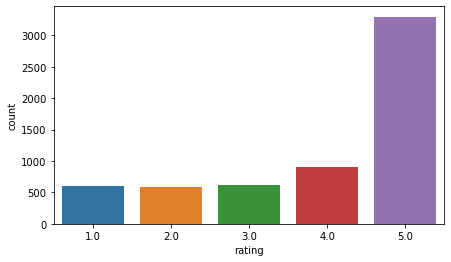

In [151]:
filter_data = dat.dropna(subset=['rating'])
plt.figure(figsize=(7,4))
sns.countplot(filter_data['rating'])

In [152]:
sum(bin_y)/len(dat)

0.5503086934757216

In [153]:
## perhaps more labels? 
## why are people taking out stars? due to delivery? shade? 
## keywords? NLP? gauge the "relevance" of the reviews
## shade matching websites? "dupes"
## 

### What are the ratings about?

- Skin tone x rating
- Cross-tabulation of skin tones and skin types vis-a-vis rating

In [154]:
train_X.groupby(['skin_tone_cat'],as_index=False).count()

,skin_tone_cat,hair_color,eye_color,skin_tone,skin_type
0,0,665,665,665,665
1,1,3530,3530,3530,3530


In [155]:
skin_tone_pearsonr = []
# for i in range(0,1):
skin_tone_pearsonr.append(st.pearsonr(pd.Series(train_X['skin_tone_cat']).iloc[:,], train_y))
    # skin_tone_pearsonr.append(skin_tone_labels[i])

In [156]:
skin_tone_pearsonr

[(-0.1453242034569282, 3.0814760726798897e-21)]

In [181]:
def plot_diff_in_means(data, col1: str, col2: str = 'rating'):
    """
    given data, plots difference in means across groups
    col1
        categorical data with groups
    col2
        continuous data for the means
    """
    # def q95(x):
    #     return x.quantile(0.95/2+0.5)
    n = data.groupby(col1)[col2].count()
    mean = data.groupby(col1)[col2].agg('mean')
    std = data.groupby(col1)[col2].agg(np.std)
    se = std / np.sqrt(n)
    # ci = data.groupby(col1)[col2].agg(q95)
    lower = st.t.interval(alpha = 0.95, df =n-1, loc = mean, scale = se)[0]
    upper = st.t.interval(alpha = 0.95, df =n-1, loc = mean, scale = se)[1]

    for upper, lower, y in zip(upper, lower, n):
        plt.plot((lower, upper), (y, y), 'ro-')
    plt.yticks(range(len(n)), list(data.groupby(col1, as_index = False)[col2].count()[col1]))
    

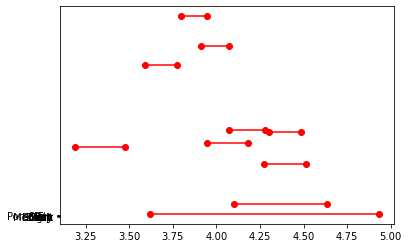

In [182]:
plot_diff_in_means(dat, 'skin_tone', 'rating')

In [172]:
len(dat.groupby('skin_tone', as_index=False)['rating'].count())
# np.quantile(a = dat.groupby('skin_tone')['rating'].count(), q = 0.95/2+.5)

10

In [ ]:
avg_rating_skin_tone = dat.groupby('skin_tone')['rating'].agg(np.std)
avg_rating_skin_tone
# .plot.bar()
# plt.show()

In [ ]:
tone_type_crosstab = pd.crosstab(train_X['skin_tone'], train_X['skin_type'], values = train_y, aggfunc = 'mean')
skin_tone_labels = train_X.groupby('skin_tone', as_index = False).count()['skin_tone']
skin_type_labels = train_X.groupby('skin_type', as_index = False).count()['skin_type']

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(tone_type_crosstab)
ax.set_yticks(np.arange(len(skin_tone_labels)), labels=skin_tone_labels)
ax.set_xticks(np.arange(len(skin_type_labels)), labels=skin_type_labels)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('rating', rotation=-90, va="bottom")

kw = dict(horizontalalignment="center",
            verticalalignment="center")
threshold = im.norm(tone_type_crosstab.max())/2
texts = []
textcolors=("black", "white")
for i in range(tone_type_crosstab.shape[0]):
    for j in range(tone_type_crosstab.shape[1]):
        kw.update(color=textcolors[int(im.norm(tone_type_crosstab.iloc[i, j]) < 0.5)])
        text = im.axes.text(j, i, round(tone_type_crosstab.iloc[i, j], 2), kw)
        texts.append(text)

### trying out classification model

#### Logistic Regression

In [ ]:
logit = LogisticRegression(penalty='none',random_state=0, max_iter=1000).fit(train_X_transform, train_y)

In [ ]:
predict_y = logit.predict_proba(val_X_transform)[:,1]
# predict_y = logit.predict(val_X_transform)

In [ ]:
# for AUC-ROC
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))

In [ ]:
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_))

### The logistic regression doesn't work particularly good...

AUC-ROC was about 0.599

#### Perhaps try another classification model?

In [ ]:
sgdc = SGDClassifier(penalty='none', loss='log', random_state=0).fit(train_X_transform, train_y)

In [ ]:
predict = sgdc.predict_proba(val_X_transform)[:, 1]
# predict_y = predict[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
text_kwargs = dict(ha='left', va='baseline', fontsize=10)
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

In [ ]:
## trying out SVM

svm = LinearSVC().fit(train_X_transform, train_y)

In [ ]:
predict_y = svm.predict(val_X_transform)

In [ ]:
confusion_matrix(val_y, predict_y)

In [ ]:
svc = SVC(probability=True).fit(train_X_transform,train_y)

In [ ]:
predict_y = svc.predict_proba(val_X_transform)[:,1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
text_kwargs = dict(ha='left', va='baseline', fontsize=10)
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

## trying out random forest models

In [ ]:
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)


In [ ]:
RF = RandomForestClassifier(random_state=0).fit(train_X_transform, train_y)
predict_y = RF.predict_proba(val_X_transform)[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
text_kwargs = dict(ha='left', va='baseline', fontsize=10)
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

In [ ]:
Ada = AdaBoostClassifier().fit(train_X_transform, train_y)
predict_y = Ada.predict_proba(val_X_transform)[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

In [ ]:
Bag = BaggingClassifier(n_estimators=1000).fit(train_X_transform, train_y)
predict_y = Bag.predict_proba(val_X_transform)[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

In [ ]:
GB = GradientBoostingClassifier().fit(train_X_transform, train_y)
predict_y = GB.predict_proba(val_X_transform)[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)

In [ ]:
GB_ada = GradientBoostingClassifier(loss='exponential').fit(train_X_transform, train_y)
predict_y = GB_ada.predict_proba(val_X_transform)[:, 1]

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
f1_scores = []
fpr = []
tpr = []

for threshold in thresholds:
    predict_y_binary = np.where(predict_y >= threshold, 1, 0)

    precisions.append(precision_score(val_y, predict_y_binary))
    recalls.append(recall_score(val_y, predict_y_binary))
    f1_scores.append(f1_score(val_y, predict_y_binary))
        
    fp = np.sum((val_y == 0) & (predict_y_binary == 1)) # true value is 0 but predict to be 1
    tp = np.sum((val_y == 1) & (predict_y_binary == 1)) # true value is 1 & predict to be 1

    fn = np.sum((val_y == 1) & (predict_y_binary == 0)) # true value is 1 but predict to be 0
    tn = np.sum((val_y == 0) & (predict_y_binary == 0)) # true value is 0 but predict to be 0

    fpr.append( fp / (fp + tn))
    tpr.append( tp / (tp + fn))


In [ ]:
## ROC & ROC-AUC
roc_auc_ = round(auc(fpr, tpr), 5)
fig, ax3 = plt.subplots(1, 1)
ax3.plot(fpr, tpr, label = "ROC")
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.text(0.55,0.2, 'AUC = {}'.format(roc_auc_), **text_kwargs)